# Finding and Visualizing Time Series Motifs of All Lengths using the Matrix Profile

## References

* The [published paper](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf)
* The [supporting website](https://sites.google.com/view/pan-matrix-profile/home)
* The [Matlab code](https://drive.google.com/file/d/15XcrNdSsHE1RU2bV-aRKi0jxNcTRnkIq/view)
* The [datasets](https://sites.google.com/view/pan-matrix-profile/datasets)

## Import Some Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import stumpy

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

## Define a custom plotting function to visualize all pan matrix profiles

This is where we need to provide a general plotting approach that would satisfy most scenarios.

In [2]:
def plot_pmp(pmp, ncolor=256, color="Greys_r", lines=None):
    PMP = pmp.P_.copy()
    nidx = pmp.n_processed_
    idx = pmp.bfs_indices_[:nidx]  # Retrieve the indices in `pmp.P_` where the matrix profile was actually computed 
    sorted_idx = np.sort(idx)
    
    PMP[PMP == np.inf] = np.nan

    # Consider normalizing the pan matrix profile
    # norm = np.sqrt(1.0/pmp.M_[:nidx])  # This normalization factor comes from the VALMOD paper
    # PMP[idx] = PMP[idx] * norm[:, np.newaxis]
    # threshold = np.nanmean(PMP[idx], axis=1) - 2 * np.nanstd(PMP[idx], axis=1)   
    # PMP[idx] = PMP[idx] * (PMP[idx] > threshold[:, np.newaxis])
    
    # Below, for each matrix profile that was computed, we take that matrix profile
    # and copy/repeat it downwards to replace other rows in `pmp.P_` where the matrix
    # profile has yet to be computed. Instead of only having lines/values
    # in the rows where matrix profiles were computed, this gives us the "blocky" look
    nrepeat = np.diff(np.append(-1, sorted_idx))
    PMP[:np.sum(nrepeat)] = np.repeat(PMP[sorted_idx], nrepeat, axis=0)
    PMP = np.nan_to_num(PMP, nan=np.nanmax(PMP))

    # bins = np.linspace(np.nanmin(PMP), np.nanmax(PMP), ncolor)
    # PMP = np.digitize(PMP, bins) - 1
    color_map = cm.get_cmap(color, ncolor)
    plt.imshow(PMP, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
    # plt.clim(0, ncolor)
    plt.colorbar()
    
    # Draw some vertical lines where each motif and nearest neighbor are located
    if lines is not None:
        for line in lines:
            plt.axvline(x=line, color='red')
    
    plt.show()

## EOG Example

See [Figure 1](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf)

In [3]:
df = pd.read_csv("https://zenodo.org/record/4733142/files/eog.csv?download=1")
m_250 = 250
m_500 = 500
mp_250 = stumpy.stump(df["EOG"], m=m_250)
mp_500 = stumpy.stump(df["EOG"], m=m_500)
motif_idx_250 = np.argmin(mp_250[:, 0])
motif_idx_500 = np.argmin(mp_500[:, 0])
nn_idx_250 = mp_250[motif_idx_250, 1]
nn_idx_500 = mp_500[motif_idx_500, 1]

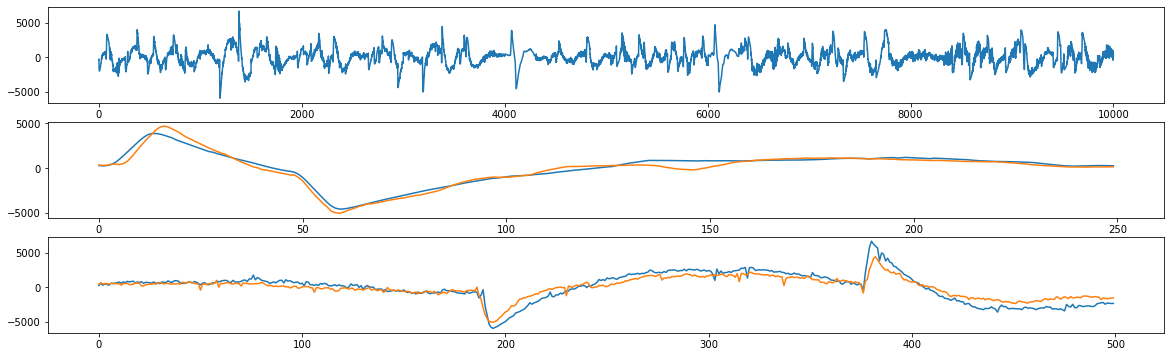

In [4]:
fig, axs = plt.subplots(3)
axs[0].plot(df["EOG"].values)
axs[1].plot(np.arange(m_250), df.iloc[motif_idx_250 : motif_idx_250 + m_250])
axs[1].plot(np.arange(m_250), df.iloc[nn_idx_250 : nn_idx_250 + m_250])
axs[2].plot(np.arange(m_500), df.iloc[motif_idx_500 : motif_idx_500 + m_500])
axs[2].plot(np.arange(m_500), df.iloc[nn_idx_500 : nn_idx_500 + m_500])
plt.show()

### Compute the Pan Matrix Profile using STIMP

Essentially, `stumpy.stimp` implements [Table 2](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf). 

In [5]:
min_m, max_m = 3, 1000
eog_pmp = stumpy.stimp(df["EOG"].values, min_m=min_m, max_m=max_m, percentage=0.01)  # This percentage controls the extent of `stumpy.scrump` completion
percent_m = 0.01  # The percentage of windows to compute
nidx = np.ceil((max_m - min_m) * percent_m).astype(int)
for _ in range(nidx):
    eog_pmp.update()

Above, we select a range of window sizes from `min_m = 3` to `max_m = 1000` and we arrange the windows in this range according to a breadth first order (this is done automatically by `stumpy.stimp` and see [slide 32](https://drive.google.com/file/d/1eT9oHOAKoi4oGkUX26V9aZIopov0Pxt5/view)) and/or [Section C](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf). The order of the window sizes to be processed can be found in `.M_` attribute:

In [6]:
print(eog_pmp.M_[:nidx])

[502 252 752 127 377 627 877  65 190 315]


Notice that we don't compute the matrix profiles (approximated using `stumpy.scrump` at 1% and with `pre-scrump` turned on) for all of the window sizes and, instead, we select only 1% of the window sizes (`percent_m = 0.01`) for this task. So, only a total of `nidx` matrix profiles were computed. Now, let's plot our pan matrix profile along with the locations of our motif pairs (vertical red lines):

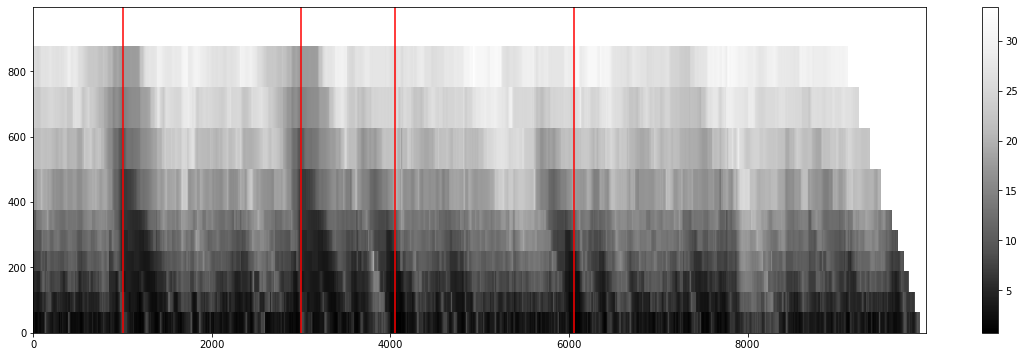

In [7]:
lines = [motif_idx_250, motif_idx_500, nn_idx_250, nn_idx_500]
plot_pmp(eog_pmp, lines=lines)

Now, we'll compute 2% more matrix profiles (for a total of 1% + 2% = 3%) for additional windows:

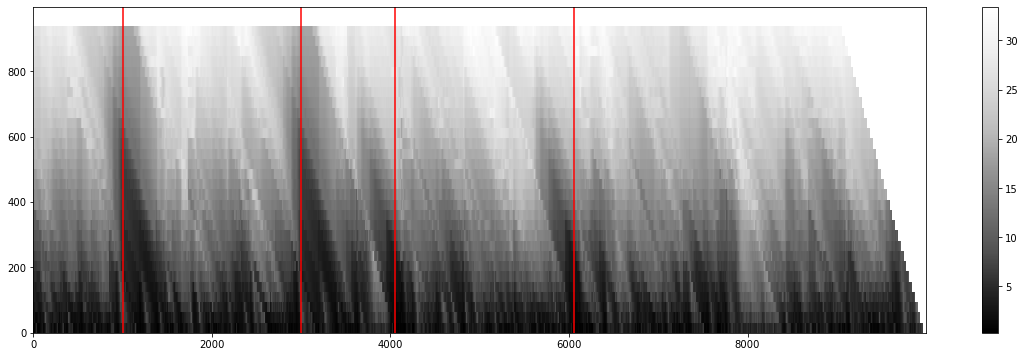

In [8]:
for _ in range(2 * nidx):
    eog_pmp.update()

plot_pmp(eog_pmp, lines=lines)

Notice how the pan matrix profile has become a bit clearer and a less "blocky"?

## Steamgen Example

In [9]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
m = 640
mp = stumpy.stump(steam_df["steam flow"], m=m)
motif_idx = np.argmin(mp[:, 0])
nn_idx = mp[motif_idx, 1]

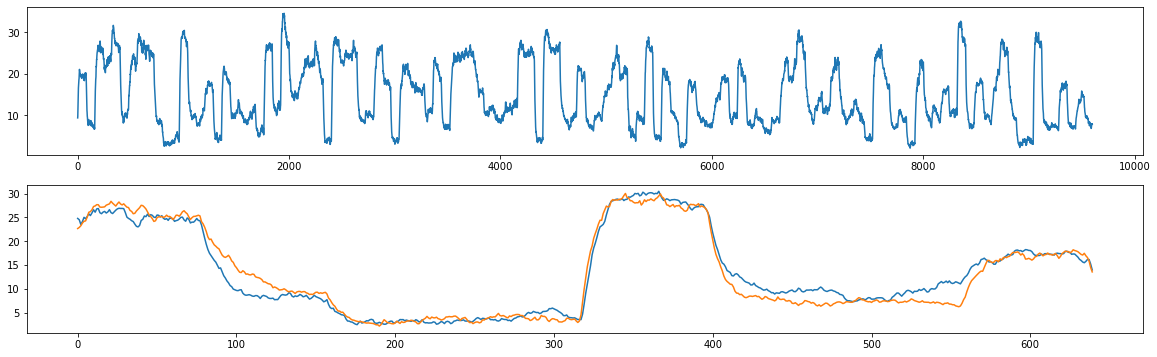

In [10]:
fig, axs = plt.subplots(2)
axs[0].plot(steam_df["steam flow"].values)
axs[1].plot(np.arange(m), steam_df["steam flow"].iloc[motif_idx : motif_idx + m])
axs[1].plot(np.arange(m), steam_df["steam flow"].iloc[nn_idx : nn_idx + m])
plt.show()

### Compute the Pan Matrix Profile using STIMP

In [11]:
min_m, max_m = 100, 3000
steam_pmp = stumpy.stimp(steam_df['steam flow'], min_m=min_m, max_m=max_m, percentage=0.01)  # This percentage controls the extent of `stumpy.scrump` completion
percent_m = 0.01  # The percentage of windows to compute
nidx = np.ceil((max_m - min_m) * percent_m).astype(int)
for _ in range(nidx):
    steam_pmp.update()

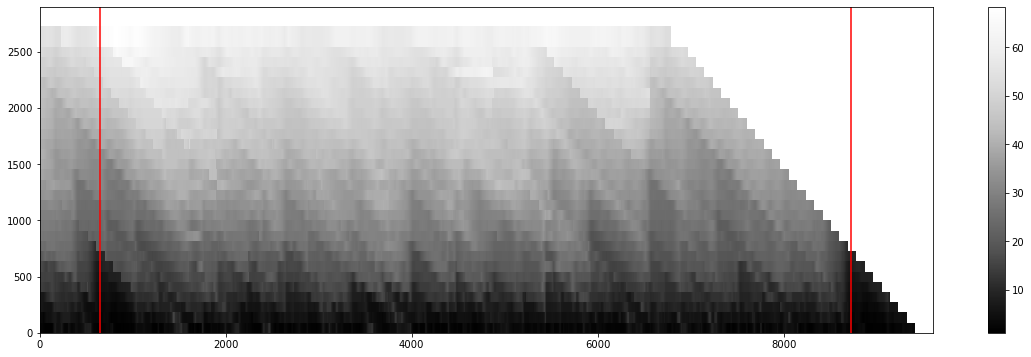

In [12]:
lines = [motif_idx, nn_idx]
plot_pmp(steam_pmp, lines=lines)